# Imports Here

In [1]:
# Step 1: Mount Google Drive
import cv2
import json
import numpy as np
import os
import random
import re
import tensorflow as tf

from google.colab import drive
from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score, roc_auc_score, jaccard_score, hamming_loss
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2, InceptionV3, Xception, VGG16, MobileNetV3Large, EfficientNetB0, MobileNetV2
from tqdm import tqdm
from typing import Any, Dict, List, Tuple


drive.mount('/content/drive')

Mounted at /content/drive


# Read The Files

In [2]:
# === PATHS ===
videos_path = "/content/drive/MyDrive/Project/cholect50-challenge-val/videos"
labels_path = "/content/drive/MyDrive/Project/cholect50-challenge-val/labels"
label_map_file = "/content/drive/MyDrive/Project/cholect50-challenge-val/label_mapping.txt"

In [3]:
# === STEP 1: LOAD triplet_id → instrument_id mapping ===
instrument_mapping = {}  # triplet_id -> instrument_id
with open(label_map_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        parts = [p.strip() for p in line.split(",") if p.strip() != ""]
        try:
            triplet_id = int(parts[0])
            instrument_id = int(parts[1])  # 2nd column = instrument ID
            instrument_mapping[triplet_id] = instrument_id
        except Exception:
            continue

# Determine number of instruments
mapped_insts = [v for v in instrument_mapping.values() if v >= 0]
num_instruments = max(mapped_insts) + 1 if mapped_insts else 6
print(f"Detected number of instruments = {num_instruments}")

# === STEP 2: BUILD X and Y ===
X, Y = [], []

for vid_folder in sorted(os.listdir(videos_path)):
    vid_path = os.path.join(videos_path, vid_folder)
    if not os.path.isdir(vid_path):
        continue

    label_file = f"{vid_folder}.json"
    label_path = os.path.join(labels_path, label_file)
    if not os.path.exists(label_path):
        print(f"⚠️ Missing label for {vid_folder}, skipping.")
        continue

    with open(label_path, "r") as f:
        data = json.load(f)

    annotations = data.get("annotations", {})

    # Build frame -> list of instrument IDs
    frame_instruments = {}
    for frame_id, triplets in annotations.items():
        try:
            frame_number = int(frame_id)
        except:
            continue

        insts_in_frame = []
        for triplet in triplets:
            if isinstance(triplet, (list, tuple)) and len(triplet) > 0:
                triplet_id = int(triplet[0])
            elif isinstance(triplet, dict):
                triplet_id = int(triplet.get("triplet_id", triplet.get("id", -1)))
            else:
                continue

            inst_id = instrument_mapping.get(triplet_id, -1)
            if inst_id != -1:
                insts_in_frame.append(inst_id)

        if insts_in_frame:
            frame_instruments[frame_number] = sorted(set(insts_in_frame))

    # Process each frame image
    frame_files = sorted([f for f in os.listdir(vid_path) if f.endswith(".png")])
    for frame_file in frame_files:
        match = re.match(r"(\d+)", frame_file)
        if not match:
            continue
        frame_number = int(match.group(1))
        if frame_number not in frame_instruments:
            continue

        img_path = os.path.join(vid_path, frame_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img)

        # Create multi-hot vector for instruments in this frame
        vec = np.zeros((num_instruments,), dtype=np.uint8)
        for inst_id in frame_instruments[frame_number]:
            if 0 <= inst_id < num_instruments:
                vec[inst_id] = 1
        Y.append(vec)

# === STEP 3: Convert to numpy arrays ===
X = np.array(X, dtype=np.float32) / 255.0
Y = np.array(Y, dtype=np.uint8)

print(f"✅ Total frames processed: {len(X)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print("Instrument indices present:", np.where(Y.sum(axis=0) > 0)[0].tolist())

Detected number of instruments = 6
✅ Total frames processed: 1209
X shape: (1209, 224, 224, 3), Y shape: (1209, 6)
Instrument indices present: [0, 1, 2, 3, 4, 5]


# Exploratory Data Analysis

In [4]:
# === STEP 4: Per-instrument frame count ===
instrument_counts = Y.sum(axis=0)  # how many frames each instrument appears in

print("\n📊 Per-Instrument Frame Counts:")
for inst_id, count in enumerate(instrument_counts):
    print(f"Instrument {inst_id}: {int(count)} frames")

print(f"\nTotal frames (sum of counts may exceed N because frames can have multiple instruments): {len(X)}")


📊 Per-Instrument Frame Counts:
Instrument 0: 456 frames
Instrument 1: 277 frames
Instrument 2: 96 frames
Instrument 3: 135 frames
Instrument 4: 143 frames
Instrument 5: 256 frames

Total frames (sum of counts may exceed N because frames can have multiple instruments): 1209


In [5]:
# === STEP 4: Per-instrument frame count ===
instrument_counts = Y.sum(axis=0)  # how many frames each instrument appears in

print("\n📊 Per-Instrument Frame Counts:")
for inst_id, count in enumerate(instrument_counts):
    print(f"Instrument {inst_id}: {int(count)} frames")

total_frames = len(X)
print(f"\nTotal frames: {total_frames}")

# === STEP 5: Multi-instrument statistics ===
instruments_per_frame = Y.sum(axis=1)  # how many instruments in each frame
multi_inst_frames = np.sum(instruments_per_frame > 1)
single_inst_frames = np.sum(instruments_per_frame == 1)
no_inst_frames = np.sum(instruments_per_frame == 0)

print(f"\n🧮 Frame composition:")
print(f"Frames with NO instruments: {int(no_inst_frames)}")
print(f"Frames with ONE instrument: {int(single_inst_frames)}")
print(f"Frames with MULTIPLE instruments: {int(multi_inst_frames)}")

# Optional: detailed breakdown (e.g., how many frames have 2, 3, 4 tools)
unique_counts, counts = np.unique(instruments_per_frame, return_counts=True)
print("\nDetailed instrument count per frame:")
for k, v in zip(unique_counts, counts):
    print(f"{int(k)} instruments: {int(v)} frames")


📊 Per-Instrument Frame Counts:
Instrument 0: 456 frames
Instrument 1: 277 frames
Instrument 2: 96 frames
Instrument 3: 135 frames
Instrument 4: 143 frames
Instrument 5: 256 frames

Total frames: 1209

🧮 Frame composition:
Frames with NO instruments: 0
Frames with ONE instrument: 1055
Frames with MULTIPLE instruments: 154

Detailed instrument count per frame:
1 instruments: 1055 frames
2 instruments: 154 frames


# Class Weights

In [6]:
instrument_counts = Y.sum(axis=0)
total_frames = len(X)
num_instruments = Y.shape[1]

from sklearn.utils.class_weight import compute_class_weight

# Flatten to single-label form for computing weights
y_single = np.argmax(Y, axis=1)  # crude approximation if you want one label per frame
# OR compute custom multi-label weights:
class_weights = total_frames / (num_instruments * instrument_counts)
class_weights = class_weights / class_weights.sum() * num_instruments  # normalize

print("⚖️ Class weights (normalized):")
for i, w in enumerate(class_weights):
    print(f"Instrument {i}: {w:.3f}")

⚖️ Class weights (normalized):
Instrument 0: 0.381
Instrument 1: 0.627
Instrument 2: 1.810
Instrument 3: 1.287
Instrument 4: 1.215
Instrument 5: 0.679


# Data Augmentation

In [7]:
def random_crop(img, crop_size=(180,180)):
    h, w, _ = img.shape
    ch, cw = crop_size
    if ch > h or cw > w:
        return cv2.resize(img, crop_size)
    top = random.randint(0, h - ch)
    left = random.randint(0, w - cw)
    cropped = img[top:top + ch, left:left + cw]
    return cv2.resize(cropped, (224, 224))

def random_rotate(img, angle_range=(-20, 20)):
    angle = random.uniform(*angle_range)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
    return rotated

# Augmentation function
def augment_image(img):
    img = random_crop(img)
    img = random_rotate(img)
    return img

# Desired balance target = max instrument frequency
max_count = int(instrument_counts.max())
print(f"\n🎯 Target frames per instrument after balancing: {max_count}")

X_balanced, Y_balanced = list(X), list(Y)

for inst_id in range(num_instruments):
    current_indices = [i for i, y in enumerate(Y) if y[inst_id] == 1]
    current_count = len(current_indices)
    needed = max_count - current_count
    if needed <= 0:
        continue

    print(f"Augmenting instrument {inst_id}: {needed} synthetic samples")

    for _ in range(needed):
        idx = random.choice(current_indices)
        img_aug = augment_image(X[idx])
        X_balanced.append(img_aug)
        Y_balanced.append(Y[idx])

X_balanced = np.array(X_balanced, dtype=np.float32)
Y_balanced = np.array(Y_balanced, dtype=np.uint8)

print(f"\n✅ Balanced dataset created.")
print(f"New X shape: {X_balanced.shape}, Y shape: {Y_balanced.shape}")


🎯 Target frames per instrument after balancing: 456
Augmenting instrument 1: 179 synthetic samples
Augmenting instrument 2: 360 synthetic samples
Augmenting instrument 3: 321 synthetic samples
Augmenting instrument 4: 313 synthetic samples
Augmenting instrument 5: 200 synthetic samples

✅ Balanced dataset created.
New X shape: (2582, 224, 224, 3), Y shape: (2582, 6)


In [8]:
# === STEP 4: Per-instrument frame count ===
instrument_counts = Y_balanced.sum(axis=0)  # how many frames each instrument appears in

print("\n📊 Per-Instrument Frame Counts:")
for inst_id, count in enumerate(instrument_counts):
    print(f"Instrument {inst_id}: {int(count)} frames")

print(f"\nTotal frames (sum of counts may exceed N because frames can have multiple instruments): {len(X_balanced)}")


📊 Per-Instrument Frame Counts:
Instrument 0: 640 frames
Instrument 1: 456 frames
Instrument 2: 456 frames
Instrument 3: 456 frames
Instrument 4: 456 frames
Instrument 5: 456 frames

Total frames (sum of counts may exceed N because frames can have multiple instruments): 2582


#Data Splits


In [9]:
import numpy as np

# X is your numpy array of shape (N, H, W, 3), values in 0..1 (if normalized)
# If X is 0..255, remove the /255.0 part

X_min = np.min(X_balanced)
X_max = np.max(X_balanced)
X_mean = np.mean(X_balanced)

print(f"✅ Pixel value stats for X:")
print(f"Min pixel value: {X_min}")
print(f"Max pixel value: {X_max}")
print(f"Mean pixel value: {X_mean:.4f}")

# Optionally, compute per-channel stats
X_mean_channels = np.mean(X_balanced, axis=(0,1,2))
X_min_channels = np.min(X_balanced, axis=(0,1,2))
X_max_channels = np.max(X_balanced, axis=(0,1,2))

print(f"\nPer-channel mean: {X_mean_channels}")
print(f"Per-channel min: {X_min_channels}")
print(f"Per-channel max: {X_max_channels}")

✅ Pixel value stats for X:
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.2817

Per-channel mean: [0.12949936 0.12949936 0.12087484]
Per-channel min: [0. 0. 0.]
Per-channel max: [1. 1. 1.]


In [10]:
# Assume X_balanced and Y_balanced are numpy arrays
# First split into train+val and test
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_balanced, Y_balanced, test_size=0.15, random_state=42, shuffle=True
)

# Then split temp into train and validation
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.15, random_state=42, shuffle=True
)

print(f"Train: {X_train.shape[0]} frames")
print(f"Validation: {X_val.shape[0]} frames")
print(f"Test: {X_test.shape[0]} frames")

Train: 1864 frames
Validation: 330 frames
Test: 388 frames


In [11]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def make_dataset(X, Y, batch_size=BATCH_SIZE, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    if training:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)
    return dataset

train_ds = make_dataset(X_train, Y_train, training=True)
val_ds   = make_dataset(X_val, Y_val, training=False)
test_ds  = make_dataset(X_test, Y_test, training=False)

In [12]:
num_instruments = Y.shape[1]

# Delete vals for Ram Management

In [13]:
del X, Y, X_temp, Y_temp, X_balanced, Y_balanced, X_test, Y_test, X_val, Y_val, X_train, Y_train

# Model Train

In [14]:
IMG_SIZE = 224
drop_rate = 0.3
num_heads = 4  # multihead attention heads
embed_dim = 128  # feature dimension for attention
num_instruments = 6
epoch_size = 20

def build_model_with_backbone(backbone_model, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_instruments):
    """
    Builds a model with a specified backbone, Multi-Head Attention, and dense layers.

    Args:
        backbone_model: The Keras application model class (e.g., MobileNetV2, ResNet50V2).
        input_shape: The input shape of the images.
        num_classes: The number of output classes.

    Returns:
        A Keras Model.
    """
    # === Backbone ===
    # Ensure include_top is False to get the convolutional base
    # Handle potential differences in input_shape argument name
    try:
        base = backbone_model(include_top=False, weights='imagenet', input_shape=input_shape, pooling=None)
    except TypeError:
         base = backbone_model(include_top=False, weights='imagenet', input_shape=input_shape)


    base.trainable = False  # Freeze backbone initially

    inp = layers.Input(shape=input_shape)
    x = base(inp)

    # Flatten spatial dimensions for attention: (batch, seq_len, channels)
    # Handle cases where base output might be flattened already or have different ranks
    if len(x.shape) == 4:
        b, h, w, c = x.shape
        x_flat = layers.Reshape((-1, c))(x)
    elif len(x.shape) == 3:
         x_flat = x
    else:
         raise ValueError(f"Unexpected backbone output shape: {x.shape}")


    # === Multi-Head Attention ===
    attention_key_dim = min(embed_dim, x_flat.shape[-1])
    attn_out = layers.MultiHeadAttention(num_heads=num_heads, key_dim=attention_key_dim)(x_flat, x_flat)
    attn_out = layers.GlobalAveragePooling1D()(attn_out)

    # === Dense Head ===
    x = layers.Dropout(drop_rate)(attn_out)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(drop_rate)(x)
    out = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs=inp, outputs=out)
    return model

print("Functions to build models with different backbones created.")

Functions to build models with different backbones created.


In [15]:
from sklearn.metrics import precision_recall_curve

def calculate_multi_label_metrics(model: Any, val_ds: Any) -> Dict[str, Any]:
    """
    Calculates multi-label metrics with automatic per-class threshold optimization.
    """

    print("Collecting true labels and generating predictions...")
    y_true = np.concatenate([y for _, y in val_ds], axis=0)
    y_probs = np.concatenate([model.predict(x) for x, _ in val_ds], axis=0)

    num_classes = y_true.shape[1]

    # ----------------------------
    # Per-class threshold optimization (maximize F1)
    # ----------------------------
    optimal_thresholds = []
    for i in range(num_classes):
        precision, recall, thresh = precision_recall_curve(y_true[:, i], y_probs[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
        best_index = np.argmax(f1_scores)
        # Edge case: threshold array is shorter by one compared to precision/recall
        if best_index >= len(thresh):
            best_index = len(thresh) - 1
        best_thresh = thresh[best_index]
        optimal_thresholds.append(best_thresh)

    print("\n🎯 Per-Class Optimal Thresholds:")
    for i, t in enumerate(optimal_thresholds):
        print(f" Class {i}: {t:.3f}")

    # Apply optimized thresholds
    y_pred = np.zeros_like(y_probs)
    for i in range(num_classes):
        y_pred[:, i] = (y_probs[:, i] >= optimal_thresholds[i]).astype(int)

    print(f"\n🔢 Total Positives After Thresholding: {y_pred.sum()}")

    # ----------------------------
    # Micro metrics
    # ----------------------------
    precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)

    # ----------------------------
    # Macro metrics
    # ----------------------------
    precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)

    # ----------------------------
    # Per-class probability metrics
    # ----------------------------
    avg_precision = [average_precision_score(y_true[:, i], y_probs[:, i]) for i in range(num_classes)]
    roc_auc = [roc_auc_score(y_true[:, i], y_probs[:, i]) for i in range(num_classes)]

    # ----------------------------
    # Multi-label specific metrics
    # ----------------------------
    jaccard_micro = jaccard_score(y_true, y_pred, average='micro', zero_division=0)
    jaccard_macro = jaccard_score(y_true, y_pred, average='macro', zero_division=0)
    hamming = hamming_loss(y_true, y_pred)

    # ----------------------------
    # Print results
    # ----------------------------
    print("\n=== Multi-label metrics (Optimized Thresholds) ===")
    print(f"Precision micro: {precision_micro:.4f}, Recall micro: {recall_micro:.4f}, F1 micro: {f1_micro:.4f}")
    print(f"Precision macro: {precision_macro:.4f}, Recall macro: {recall_macro:.4f}, F1 macro: {f1_macro:.4f}")
    print(f"Jaccard index (micro): {jaccard_micro:.4f}, Jaccard index (macro): {jaccard_macro:.4f}")
    print(f"Hamming loss: {hamming:.4f}")
    print("Average precision per class:", np.round(avg_precision, 3))
    print("ROC-AUC per class:", np.round(roc_auc, 3))

    return {
        'optimal_thresholds': optimal_thresholds,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'f1_micro': f1_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'jaccard_micro': jaccard_micro,
        'jaccard_macro': jaccard_macro,
        'hamming_loss': hamming,
        'avg_precision_per_class': avg_precision,
        'roc_auc_per_class': roc_auc,
        'total_positives_after_thresholding': int(y_pred.sum()) # Adding total positives
    }

In [16]:
model = build_model_with_backbone(MobileNetV2)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 49, 1280)  │          0 │ mobilenetv2_1.00… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 1280)  │  2,624,256 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    163,968 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        774 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,046,982 (19.25 MB)

 Trainable params: 2,788,998 (10.64 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
model.compile(
      optimizer=tf.keras.optimizers.Adam(1e-4),
      loss='binary_crossentropy',
      metrics=[tf.keras.metrics.AUC(curve='ROC', multi_label=True)]
)

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epoch_size,
    callbacks=callbacks
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - auc: 0.5242 - loss: 0.5570 - val_auc: 0.8234 - val_loss: 0.4416 - learning_rate: 1.0000e-04
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - auc: 0.7440 - loss: 0.4230 - val_auc: 0.8919 - val_loss: 0.3305 - learning_rate: 1.0000e-04
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - auc: 0.8801 - loss: 0.3245 - val_auc: 0.9356 - val_loss: 0.2535 - learning_rate: 1.0000e-04
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - auc: 0.9306 - loss: 0.2520 - val_auc: 0.9579 - val_loss: 0.2083 - learning_rate: 1.0000e-04
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - auc: 0.9604 - loss: 0.1956 - val_auc: 0.9684 - val_loss: 0.1825 - learning_rate: 1.0000e-04
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - auc: 0.9692 - loss: 0.1697 - val_auc: 0.9729 - val_loss: 0.1618 - learning_rate: 1.0000e-04
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - auc: 0.9849 - loss: 0.1236 - val_auc: 0.9761 - val_loss: 0.1511 - learni

In [19]:
print(calculate_multi_label_metrics(model, val_ds))

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step

🎯 Per-Class Optimal Thresholds:
 Class 0: 0.457
 Class 1: 0.613
 Class 2: 0.631
 Class 3: 0.365
 Class 4: 0.118
 Class 5: 0.644

🔢 Total Positives After Thresholding: 367.0

=== Multi-label metrics (Optimized Thresholds) ===
Precision micro: 0.9046, Recall micro: 0.8783, F1 micro: 0.8913
Precision macro: 0.9081, Recall macro: 0.8798, F1 macro: 0.8923
Jaccard index (micro): 0.8039, Jaccard index (macro): 0.8064
Hamming loss: 0.0409
Average precision per class: [0.926 0.947 0.987 0.952 0.934 0.939]
ROC-AUC per class: [0.97  0.98  0.997 0.98  0.98  0.98 ]
{'optimal_thresholds': [np.float32(0.45743382), np.float32(0.6125257), np.float32(0.6311226), np.float32(0.36477286), np.float32(0.117673606), np.float32(0.6441547)], 'precision_micro': 0.9046321525885559, 'recall_micro': 0.8783068783068783, 'f1_micro': 0.8912751677852349, 'precision_macro': 0.9081478070887216, 'recall_macro

In [20]:
def focal_loss_with_class_weights(class_weights, gamma=2.0, alpha=0.25):
    class_weights = tf.constant(class_weights, dtype=tf.float32)

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        bce = -(y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        fl = alpha * tf.pow(1 - y_pred, gamma) * y_true * bce + \
             (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true) * bce
        # apply per-class weights
        weighted_fl = fl * class_weights
        return tf.reduce_mean(weighted_fl)
    return loss

In [21]:
loss_fn = focal_loss_with_class_weights(class_weights, gamma=2.0, alpha=0.25)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=loss_fn,
    metrics=[tf.keras.metrics.AUC(curve='PR', multi_label=True, name='pr_auc')]
)

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epoch_size,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
    ]
)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - loss: 0.0029 - pr_auc: 0.9975 - val_loss: 0.0210 - val_pr_auc: 0.9538 - learning_rate: 1.0000e-04
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0015 - pr_auc: 0.9993 - val_loss: 0.0211 - val_pr_auc: 0.9496 - learning_rate: 1.0000e-04
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 0.0010 - pr_auc: 0.9989 - val_loss: 0.0204 - val_pr_auc: 0.9502 - learning_rate: 1.0000e-04
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - loss: 7.3212e-04 - pr_auc: 0.9996 - val_loss: 0.0220 - val_pr_auc: 0.9481 - learning_rate: 1.0000e-04
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 5.2109e-04 - pr_auc: 0.9998 - val_loss: 0.0208 - val_pr_auc: 0.9491 - learning_rate: 1.0000e-04
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 5.1811e-04 - pr_auc: 0.9997 - val_loss: 0.0205 - val_pr_auc: 0.9496 - learning_rate: 5.0000e-05


In [23]:
print(calculate_multi_label_metrics(model, val_ds))

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step

🎯 Per-Class Optimal Thresholds:
 Class 0: 0.528
 Class 1: 0.470
 Class 2: 0.234
 Class 3: 0.391
 Class 4: 0.140
 Class 5: 0.452

🔢 Total Positives After Thresholding: 384.0

=== Multi-label metrics (Optimized Thresholds) ===
Precision micro: 0.8854, Recall micro: 0.8995, F1 micro: 0.8924
Precision macro: 0.8874, Recall macro: 0.9040, F1 macro: 0.8939
Jaccard index (micro): 0.8057, Jaccard index (macro): 0.8091
Hamming loss: 0.0414
Average precision per class: [0.935 0.942 0.986 0.96  0.934 0.942]
ROC-AUC per class: [0.973 0.976 0.997 0.982 0.982 0.983]
{'optimal_thresholds': [np.float32(0.5283747), np.float32(0.47005582), np.float32(0.23415378), np.float32(0.3905428), np.float32(0.14037864), np.float32(0.4521494)], 'precision_micro': 0.8854166666666666, 'recall_micro': 0.8994708994708994, 'f1_micro': 0.8923884514435696, 'precision_macro': 0.8874191855714767, 'recall_macro': 

In [24]:
print(calculate_multi_label_metrics(model, test_ds))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step

🎯 Per-Class Optimal Thresholds:
 Class 0: 0.418
 Class 1: 0.446
 Class 2: 0.535
 Class 3: 0.598
 Class 4: 0.466
 Class 5: 0.281

🔢 Total Positives After Thresholding: 423.0

=== Multi-label metrics (Optimized Thresholds) ===
Precision micro: 0.8983, Recall micro: 0.8656, F1 micro: 0.8817
Precision macro: 0.9050, Recall macro: 0.8712, F1 macro: 0.8851
Jaccard index (micro): 0.7884, Jaccard index (macro): 0.7945
Hamming loss: 0.0438
Average precision per class: [0.929 0.948 0.956 0.914 0.917 0.934]
ROC-AUC per class: [0.961 0.988 0.989 0.962 0.985 0.972]
{'optimal_thresholds': [np.float32(0.41801658), np.float32(0.44638148), np.float32(0.5346521), np.float32(0.59774756), np.float32(0.4659278), np.float32(0.28093264)], 'precision_micro': 0.8983451536643026, 'recall_micro': 0.8656036446469249, 'f1_micro': 0.8816705336426914, 'precision_mac

# Task
Create a loop to iterate through the list of model backbones ['ResNet50V2', 'InceptionV3', 'Xception', 'VGG16', 'MobileNetV3Large', 'EfficientNetB0', 'MobileNetV2'], build, compile, train, and evaluate each model using the `build_model_with_backbone`, `focal_loss_with_class_weights`, `train_ds`, `val_ds`, `test_ds`, and `calculate_multi_label_metrics` functions. Print the evaluation results for each model.

## Define model list

### Subtask:
Create a list of the model backbones to iterate through.


In [31]:
model_backbones = ['ResNet50V2', 'InceptionV3', 'Xception', 'VGG16', 'MobileNetV3Large', 'EfficientNetB0', 'MobileNetV2']
# model_backbones = ['MobileNetV2']

**Reasoning**:
The subtask is to create a list of model backbone names. This can be done by creating a Python list with the specified names.



## Loop through models

### Subtask:
Iterate through the list of models. For each model, build, compile, train, and evaluate the model.


In [32]:
import pandas as pd

# List to store evaluation results for each model
all_results = []

# Iterate through the list of model backbones
for backbone_name in model_backbones:
    print(f"\n--- Processing Model: {backbone_name} ---")

    # Step 3: Build model
    print("Building model...")
    try:
        backbone_class = globals()[backbone_name]
        model = build_model_with_backbone(backbone_class)
        print(f"Model {backbone_name} built successfully.")
        # model.summary() # Optional: Print summary

        # Extract trainable parameters (in millions)
        trainable_params = model.count_params() / 1_000_000.0
        print(f"Trainable parameters: {trainable_params:.2f}M")

    except Exception as e:
        print(f"Error building model {backbone_name}: {e}")
        continue  # Skip to the next backbone

    # Step 4: Compile model
    print("Compiling model...")
    try:
        # Use the focal loss with class weights and PR AUC metric
        loss_fn = focal_loss_with_class_weights(class_weights, gamma=2.0, alpha=0.25)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=loss_fn,
            metrics=[tf.keras.metrics.AUC(curve='PR', multi_label=True, name='pr_auc')]
        )
        print("Model compiled successfully.")
    except Exception as e:
        print(f"Error compiling model {backbone_name}: {e}")
        del model # Free up memory
        continue # Skip to the next backbone


    # Step 5: Train model
    print("Training model...")
    try:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epoch_size,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
            ],
            verbose=0 # Suppress verbose output during loop
        )
        print(f"Model {backbone_name} trained successfully.")
    except Exception as e:
        print(f"Error training model {backbone_name}: {e}")
        del model # Free up memory
        continue # Skip to the next backbone


    # Step 6: Evaluate model and collect results
    print("Evaluating model on test set...")
    try:
        test_results = calculate_multi_label_metrics(model, test_ds)
        print(f"\n--- Evaluation Results for {backbone_name} ---")

        # Add model name and trainable parameters to the results dictionary
        test_results['Model'] = backbone_name
        test_results['Trainable Params (M)'] = trainable_params

        # Append results to the list
        all_results.append(test_results)

        # Step 7: Save the trained model
        model_save_path = f"/content/drive/MyDrive/Project/surgical_tool_recognition_model_{backbone_name}.keras"
        model.save(model_save_path)
        print(f"Model saved to: {model_save_path}")


    except Exception as e:
        print(f"Error evaluating or saving model {backbone_name}: {e}")


    # Clean up for the next iteration to free up memory
    del model
    tf.keras.backend.clear_session()
    print(f"Finished processing {backbone_name}. Memory cleared.")

print("\n--- All models processed. ---")

# Convert results to DataFrame and save to CSV
if all_results:
    results_df = pd.DataFrame(all_results)

    # Define the path to save the CSV
    results_csv_path = "/content/drive/MyDrive/Project/surgical_tool_recognition_model_evaluation_results.csv"

    try:
        results_df.to_csv(results_csv_path, index=False)
        print(f"\n✅ Evaluation results saved to: {results_csv_path}")
        display(results_df) # Display the DataFrame
    except Exception as e:
        print(f"\nError saving results to CSV: {e}")
else:
    print("\nNo results to save.")


--- Processing Model: ResNet50V2 ---
Building model...
Model ResNet50V2 built successfully.
Trainable parameters: 28.03M
Compiling model...
Model compiled successfully.
Training model...
Model ResNet50V2 trained successfully.
Evaluating model on test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

🎯 Per-Class Optimal Thresholds:
 Class 0: 0.358
 Class 1: 0.476
 Class 2: 0.407
 Class 3: 0.369
 Class 4: 0.362
 Class 5: 0.352

🔢 Total Positives After Thresholding: 440.0

=== Multi-label metrics (Optimized Thresholds) ===
Precision micro: 0.8591, Recall micro: 0.8610, F1 micro: 0.8601
Precision macro: 0.8757, Recall macro: 0.8692, F1 macro: 0.8706
Jaccard index (micro): 0.7545, Jaccard index (macro): 0.7739
Hamming loss: 0.0528
Average precision per class: [0.848 0.935 0.973 0.935 0.936 0.946]
ROC-AUC per class: [0.911 0.977 0.993 0.971 0.977 0.981]

--- Evaluation Results for Res

,optimal_thresholds,precision_micro,recall_micro,f1_micro,precision_macro,recall_macro,f1_macro,jaccard_micro,jaccard_macro,hamming_loss,avg_precision_per_class,roc_auc_per_class,total_positives_after_thresholding,Model,Trainable Params (M)
0,"[0.35802737, 0.47587433, 0.4067445, 0.36894798...",0.859091,0.861048,0.860068,0.875698,0.869229,0.870567,0.754491,0.773852,0.052835,"[0.8483378731313469, 0.9348567354642499, 0.973...","[0.9111183780248528, 0.9770748544639638, 0.992...",440,ResNet50V2,28.025734
1,"[0.3061285, 0.4459844, 0.3783584, 0.4952009, 0...",0.869767,0.851936,0.860759,0.897238,0.847610,0.868020,0.755556,0.768450,0.051976,"[0.8783170468912054, 0.8935373510206286, 0.972...","[0.9461739699149772, 0.9637834217711606, 0.993...",430,InceptionV3,26.263718
2,"[0.29237866, 0.5436671, 0.40347937, 0.34821516...",0.860619,0.886105,0.873176,0.882241,0.886699,0.882678,0.774900,0.792149,0.048540,"[0.8799010350671672, 0.9752179719760602, 0.968...","[0.9429692609548724, 0.993920972644377, 0.9928...",452,Xception,25.322414
3,"[0.32862273, 0.4807956, 0.24896492, 0.3888355,...",0.736142,0.756264,0.746067,0.754257,0.763548,0.755048,0.594982,0.613172,0.097079,"[0.7008875983971261, 0.8798824707527207, 0.918...","[0.8402550686723349, 0.9501313688114987, 0.964...",451,VGG16,15.831750
4,"[0.29820913, 0.26074338, 0.2817382, 0.2835158,...",0.270158,0.740319,0.395859,0.271171,0.712616,0.386983,0.246773,0.240614,0.426117,"[0.38351366671322856, 0.4112627858100841, 0.25...","[0.5457488554610856, 0.6488588944412962, 0.629...",1203,MobileNetV3Large,5.088710
5,"[0.3148192, 0.27938196, 0.26762557, 0.27826416...",0.221734,0.804100,0.347612,0.276950,0.796308,0.363808,0.210369,0.224886,0.569158,"[0.32344167666986, 0.27022934610209554, 0.1470...","[0.5747220405493786, 0.5892277574571119, 0.414...",1592,EfficientNetB0,6.838569
6,"[0.27427423, 0.4400217, 0.39832813, 0.45466495...",0.902098,0.881549,0.891705,0.916538,0.879813,0.896534,0.804574,0.813091,0.040378,"[0.9215329331170157, 0.9498181467223464, 0.959...","[0.9553956834532373, 0.9928906290247798, 0.987...",429,MobileNetV2,5.046982


✅ Evaluation results loaded from: /content/drive/MyDrive/Project/surgical_tool_recognition_model_evaluation_results.csv


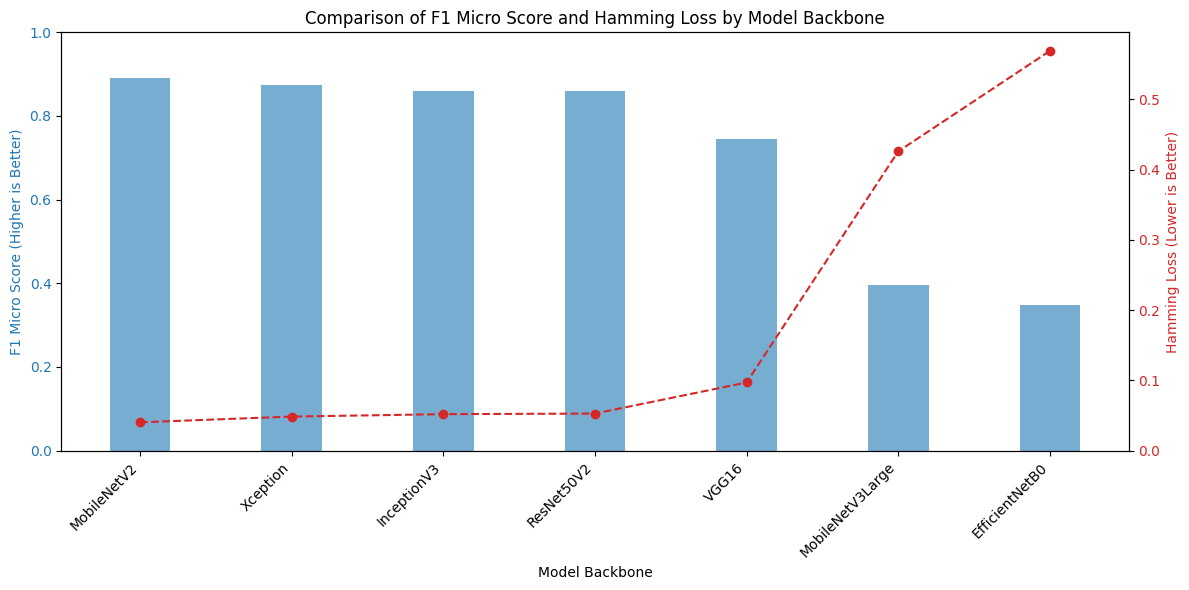

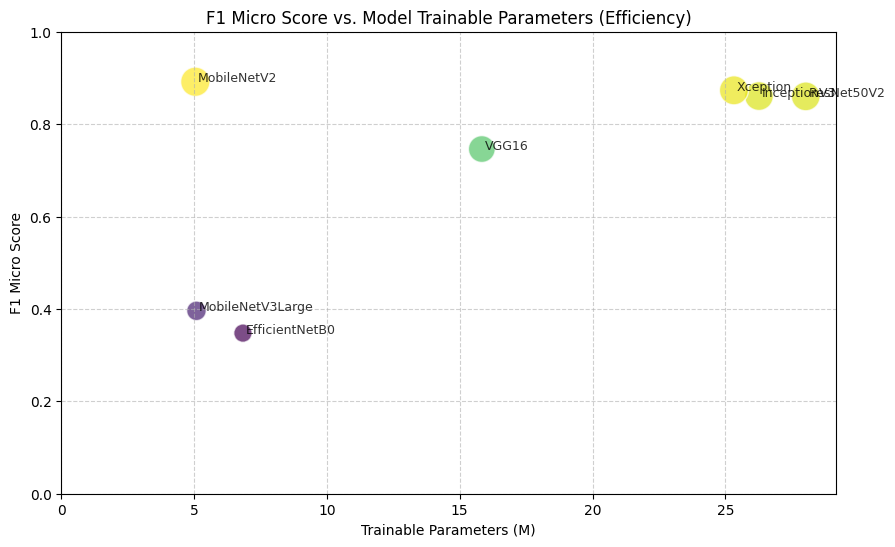

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the path to the CSV file
results_csv_path = "/content/drive/MyDrive/Project/surgical_tool_recognition_model_evaluation_results.csv"

try:
    # Read the data from the CSV file
    df = pd.read_csv(results_csv_path)
    print(f"✅ Evaluation results loaded from: {results_csv_path}")
except FileNotFoundError:
    print(f"Error: The file '{results_csv_path}' was not found.")
    # Handle the error, maybe skip plotting or use placeholder data
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
except Exception as e:
    print(f"Error reading CSV file: {e}")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later


if not df.empty:
    # Rename columns for clarity in plots if necessary (adjust as needed)
    # Example: df = df.rename(columns={'f1_micro': 'F1 Micro', 'hamming_loss': 'Hamming Loss'})

    # Sort by F1 Micro for better visualization in the first plot
    df_sorted = df.sort_values(by='f1_micro', ascending=False)

    # ----------------------------------------------------------------------
    ## Chart 1: F1 Micro Score and Hamming Loss Comparison
    # ----------------------------------------------------------------------

    # Create a figure with two subplots (sharing the Model axis)
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot F1 Micro on the left y-axis (ax1)
    color = 'tab:blue'
    ax1.set_xlabel('Model Backbone')
    ax1.set_ylabel('F1 Micro Score (Higher is Better)', color=color)
    ax1.bar(df_sorted['Model'], df_sorted['f1_micro'], color=color, alpha=0.6, width=0.4, align='center')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 1.0)
    x_positions = ax1.get_xticks() # Get the auto-generated positions
    ax1.set_xticks(x_positions)    # Set the positions explicitly
    ax1.set_xticklabels(df_sorted['Model'], rotation=45, ha="right") # Apply the labels

    # Create a second y-axis for Hamming Loss
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Hamming Loss (Lower is Better)', color=color)
    ax2.plot(df_sorted['Model'], df_sorted['hamming_loss'], color=color, marker='o', linestyle='--')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0)

    plt.title('Comparison of F1 Micro Score and Hamming Loss by Model Backbone')
    fig.tight_layout()
    plt.savefig('model_comparison_f1_hamming.png')
    # Command to display the first chart
    plt.show()
    plt.close(fig)

    # ----------------------------------------------------------------------
    ## Chart 2: F1 Micro vs. Trainable Parameters (Efficiency Trade-off)
    # ----------------------------------------------------------------------

    plt.figure(figsize=(10, 6))
    plt.scatter(
        df['Trainable Params (M)'], # Use the column from the CSV
        df['f1_micro'],          # Use the column from the CSV
        s=df['f1_micro'] * 500,  # Size based on F1 micro
        c=df['f1_micro'],        # Color based on F1 micro
        cmap='viridis',
        alpha=0.7,
        edgecolors='w',
        linewidths=1
    )

    # Annotate each point with the model name
    for i, row in df.iterrows():
        plt.annotate(
            row['Model'],
            (row['Trainable Params (M)'] + 0.1, row['f1_micro']), # Use columns from CSV
            fontsize=9,
            alpha=0.8
        )

    plt.xlabel('Trainable Parameters (M)')
    plt.ylabel('F1 Micro Score')
    plt.title('F1 Micro Score vs. Model Trainable Parameters (Efficiency)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xlim(0)
    plt.ylim(0, 1.0)

    plt.savefig('model_efficiency_tradeoff.png')
    # Command to display the second chart
    plt.show()
    plt.close()
else:
    print("DataFrame is empty. Cannot generate plots.")

✅ Evaluation results loaded from: /content/drive/MyDrive/Project/surgical_tool_recognition_model_evaluation_results.csv


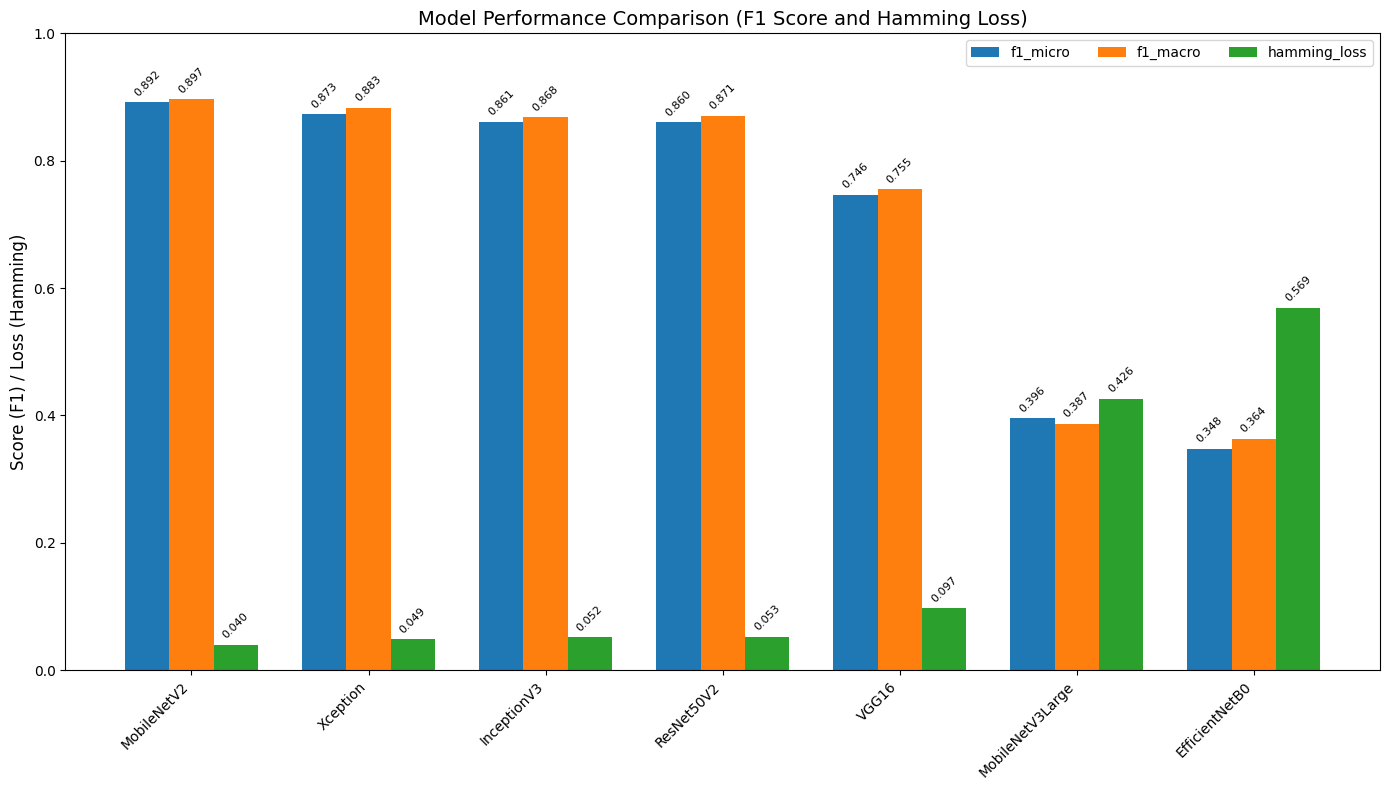

--- Model Performance Metrics ---
| Model            |   f1_micro |   f1_macro |   hamming_loss |
|:-----------------|-----------:|-----------:|---------------:|
| MobileNetV2      |   0.891705 |   0.896534 |      0.040378  |
| Xception         |   0.873176 |   0.882678 |      0.0485395 |
| InceptionV3      |   0.860759 |   0.86802  |      0.0519759 |
| ResNet50V2       |   0.860068 |   0.870567 |      0.0528351 |
| VGG16            |   0.746067 |   0.755048 |      0.097079  |
| MobileNetV3Large |   0.395859 |   0.386983 |      0.426117  |
| EfficientNetB0   |   0.347612 |   0.363808 |      0.569158  |

--- Model Parameter Comparison (in Millions) ---
| Model            |   Trainable Params (M) |
|:-----------------|-----------------------:|
| ResNet50V2       |               28.0257  |
| InceptionV3      |               26.2637  |
| Xception         |               25.3224  |
| VGG16            |               15.8317  |
| EfficientNetB0   |                6.83857 |
| MobileNetV3Large

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the path to the CSV file
results_csv_path = "/content/drive/MyDrive/Project/surgical_tool_recognition_model_evaluation_results.csv"

try:
    # Read the data from the CSV file
    df = pd.read_csv(results_csv_path)
    print(f"✅ Evaluation results loaded from: {results_csv_path}")
except FileNotFoundError:
    print(f"Error: The file '{results_csv_path}' was not found.")
    # Handle the error, maybe skip plotting or use placeholder data
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later
except Exception as e:
    print(f"Error reading CSV file: {e}")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later


if not df.empty:
    # Sort by F1 micro for better visualization (descending order)
    df_sorted = df.sort_values(by='f1_micro', ascending=False).reset_index(drop=True)

    # 1. Performance Metrics Bar Chart
    metrics = ['f1_micro', 'f1_macro', 'hamming_loss'] # Use column names from the CSV
    x = np.arange(len(df_sorted['Model']))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax1 = plt.subplots(figsize=(14, 8))

    for i, metric in enumerate(metrics):
        offset = width * multiplier
        rects = ax1.bar(x + offset, df_sorted[metric], width, label=metric)
        ax1.bar_label(rects, padding=3, fmt='%.3f', rotation=45, fontsize=8)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax1.set_ylabel('Score (F1) / Loss (Hamming)', fontsize=12)
    ax1.set_title('Model Performance Comparison (F1 Score and Hamming Loss)', fontsize=14)
    ax1.set_xticks(x + width, df_sorted['Model'], rotation=45, ha='right', fontsize=10)
    ax1.legend(loc='upper right', ncol=3)
    ax1.set_ylim(0, 1.0)
    plt.tight_layout()

    plt.savefig('model_performance_comparison.png')
    plt.show()
    plt.close()

    # 2. Parameter Count DataFrame
    # Create a DataFrame for parameter comparison and print as markdown
    # Use column names from the CSV
    params_df = df[['Model', 'Trainable Params (M)']].sort_values(
        by='Trainable Params (M)', ascending=False
    ).reset_index(drop=True)


    print("--- Model Performance Metrics ---")
    print(df_sorted[['Model', 'f1_micro', 'f1_macro', 'hamming_loss']].to_markdown(index=False)) # Use column names from the CSV

    print("\n--- Model Parameter Comparison (in Millions) ---")
    print(params_df.to_markdown(index=False))

else:
    print("DataFrame is empty. Cannot generate plots or tables.")